In [1]:
import pymc3 as pm
import theano
import toytree
import pandas as pd
import numpy as np
import sproc
from pymc3.distributions.dist_math import normal_lccdf, normal_lcdf

In [2]:
data = pd.read_csv(pm.get_data("radon.csv"))

In [5]:
data

# Lit, biogeo need to be handled like county codes are in the example.

Unnamed: 0   idnum state state2  stfips    zip  region  typebldg  floor  \
0             0  5081.0    MN     MN    27.0  55735     5.0       1.0    1.0   
1             1  5082.0    MN     MN    27.0  55748     5.0       1.0    0.0   
2             2  5083.0    MN     MN    27.0  55748     5.0       1.0    0.0   
3             3  5084.0    MN     MN    27.0  56469     5.0       1.0    0.0   
4             4  5085.0    MN     MN    27.0  55011     3.0       1.0    0.0   
..          ...     ...   ...    ...     ...    ...     ...       ...    ...   
914         914  5995.0    MN     MN    27.0  55363     5.0       1.0    0.0   
915         915  5996.0    MN     MN    27.0  55376     5.0       1.0    0.0   
916         916  5997.0    MN     MN    27.0  55376     5.0       1.0    0.0   
917         917  5998.0    MN     MN    27.0  56297     5.0       1.0    0.0   
918         918  5999.0    MN     MN    27.0  56297     5.0       1.0    0.0   

     room  ... pcterr        adjwt  dupflag  zipflag  cntyfips  \
0     3.0  ...    9.7  1146.499190      1.0      0.0       1.0   
1     4.0  ...   14.5   471.366223      0.0      0.0       1.0   
2     4.0  ...    9.6   433.316718      0.0      0.0       1.0   
3     4.0  ...   24.3   461.623670      0.0      0.0       1.0   
4     4.0  ...   13.8   433.316718      0.0      0.0       3.0   
..    ...  ...    ...          ...      ...      ...       ...   
914   4.0  ...    4.5  1146.499190      0.0      0.0     171.0   
915   7.0  ...    8.3  1105.956867      0.0      0.0     171.0   
916   4.0  ...    5.2  1214.922779      0.0      0.0     171.0   
917   4.0  ...    9.6  1177.377355      0.0      0.0     173.0   
918   4.0  ...    8.0  1214.922779      0.0      0.0     173.0   

              county     fips      Uppm  county_code  log_radon  
0             AITKIN  27001.0  0.502054            0   0.832909  
1             AITKIN  27001.0  0.502054            0   0.832909  
2             AITKIN  27001.0  0.502054            0   1.098612  
3             AITKIN  27001.0  0.502054            0   0.095310  
4              ANOKA  27003.0  0.428565            1   1.163151  
..               ...      ...       ...          ...        ...  
914           WRIGHT  27171.0  0.913909           83   1.871802  
915           WRIGHT  27171.0  0.913909           83   1.526056  
916           WRIGHT  27171.0  0.913909           83   1.629241  
917  YELLOW MEDICINE  27173.0  1.426590           84   1.335001  
918  YELLOW MEDICINE  27173.0  1.426590           84   1.098612  

[919 rows x 30 columns]

## What goes into a hierarchical linear model for oak RI?

Y is RI and what we want to determine.  The censored model means Y must be between 0 and 1.

X is genetic distance.  For all pairs, calculate genetic distance on toytree objeect.

B1 (a) is slope: normal prior, mu = 0 and sigma = 5.

B0 (b) is intercept: normal prior, mu = 0 and sigma = 1.

C values combine additively with B1: normal prior, mu = 0 and sigma = 1.  Like slope and intercept, I don't know these in advance but I can use priors to guess at what they should be.

Error term: lognormal prior, log mean = -1 and log SD = 1.

*The simplest output is a traceplot distribution, but ultimately I want values assinged to a heatmap.  To do that, get MAP values for each pair.*

*On the heatmap, we have RI = 0 to denote complete compatibility and 1 for the opposite.  The biogeo and lit params should follow: 0 for overlapping/recorded, 1 for not overlapping/not recorded.*

## Organize parts of model from tree

The tutorial includes an "observed" argument: the radon data already known.  The analogue for oak hybrids would be previously known hybrid pair data, from the generative model.

The model will have two additional binary parameters: geographic range overlap (from sproc), and literature record of hybrid evidence.

By default, the model will try to assign a unique C value per species.  To constrain by clade (or entire dataset), I need to index clades and have that be part of the normal prior that sets up the distribution.  I would also need a shape argument for slope/intercept: number of clades.

## Tree and dataframe setup

In [47]:
# Load tree; drop outgroups, duplicates and tips with no data; and show tip labels.
tree = toytree.tree("/home/henry/oaks-thesis/moto/newick-cal-crown-lambda0_basic_scaffold05.tree")
atree = tree.drop_tips(names = ['Quercus|Quercus|Leucomexicana|Q.laeta', 'Quercus|Lobatae|Erythromexicana|Q.conzattii',
                       'Quercus|Quercus|Leucomexicana|Q.arizonica', 'SRR5984321', 'SRR5632417', 'SRR5632562'])
btree = atree.drop_tips(wildcard = "Chrysolepis")
ctree = btree.drop_tips(wildcard = "Notholithocarpus")
dtree = ctree.drop_tips(wildcard = "Lithocarpus")
etree = dtree.drop_tips(wildcard = "SRR")
ftree = etree.drop_tips(wildcard = "reference")
gtree = ftree.drop_tips(names = ['Quercus|Quercus|Leucomexicana|Q.species', 'Quercus|Quercus|Roburoids|Q.vulcanica',
                                'Quercus|Quercus|Roburoids|Q.imeretina', 'Quercus|Virentes|nan|Q.sagraeana',
                                'Quercus|Lobatae|Erythromexicana|Q.lowilliamsii', 
                                 'Quercus|Lobatae|Agrifoliae|Q.oxyadenia', 'Quercus|Quercus|Roburoids|Q.kotschyana',
                                'Quercus|Quercus|Roburoids|Q.cedrorum', 'Quercus|Quercus|Dumosae|Q.pacifica',
                                 'Quercus|Lobatae|Erythromexicana|Q.sartorii',
                                'Quercus|Lobatae|Agrifoliae|Q.tamalpaiensis','Quercus|Lobatae|Agrifoliae|Q.shrevei',
                                 'Cerris|Cyclobalanopsis|Semiserrata|Q.litoralis', 
                                 'Cerris|Cyclobalanopsis|Acuta|Q.ciliaris', 'Cerris|Cyclobalanopsis|Acuta|Q.stewardiana',
                                'Cerris|Cyclobalanopsis|Semiserrata|Q.patelliformis',
                                'Cerris|Cyclobalanopsis|Glauca|Q.multinervis', 'Cerris|Ilex|Himalayansubalpine|Q.sp.nov.'])
gtree.get_tip_labels()

['Quercus|Quercus|Leucomexicana|Q.ajoensis',
 'Quercus|Quercus|Leucomexicana|Q.turbinella',
 'Quercus|Quercus|Leucomexicana|Q.toumeyi',
 'Quercus|Quercus|Leucomexicana|Q.oblongifolia',
 'Quercus|Quercus|Leucomexicana|Q.chihuahuensis',
 'Quercus|Quercus|Leucomexicana|Q.grisea',
 'Quercus|Quercus|Leucomexicana|Q.glaucoides',
 'Quercus|Quercus|Leucomexicana|Q.diversifolia',
 'Quercus|Quercus|Leucomexicana|Q.deserticola',
 'Quercus|Quercus|Leucomexicana|Q.peduncularis',
 'Quercus|Quercus|Leucomexicana|Q.obtusata',
 'Quercus|Quercus|Leucomexicana|Q.greggii',
 'Quercus|Quercus|Leucomexicana|Q.rugosa',
 'Quercus|Quercus|Leucomexicana|Q.glabrescens',
 'Quercus|Quercus|Leucomexicana|Q.striatula',
 'Quercus|Quercus|Leucomexicana|Q.potosina',
 'Quercus|Quercus|Leucomexicana|Q.purulhana',
 'Quercus|Quercus|Leucomexicana|Q.segoviensis',
 'Quercus|Quercus|Leucomexicana|Q.nudinervis',
 'Quercus|Quercus|Leucomexicana|Q.subspathulata',
 'Quercus|Quercus|Leucomexicana|Q.resinosa',
 'Quercus|Quercus|Leuc

In [48]:
gtree.draw(layout='r', scalebar=True);

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="t0fedc1c6ce624a43a4dccc1e0f9e3aaf" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 500.0 1000.0" width="500.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Quercus|Quercus|Leucomexicana|Q.ajoensis Quercus|Quercus|Leucomexicana|Q.turbinella Quercus|Quercus|Leucomexicana|Q.toumeyi Quercus|Quercus|Leucomexicana|Q.oblongifolia Quercus|Quercus|Leucomexicana|Q.chihuahuensis Quercus|Quercus|Leucomexicana|Q.grisea Quercus|Quercus|Leucomexicana|Q.glaucoides Quercus|Quercus|Leucomexicana|Q.diversifolia Quercus|Quercus|Leucomexicana|Q.deserticola Quercus|Quercus|Leucomexicana|Q.peduncularis Quercus|Quercus|Leucomexicana|Q.obtusata Quercus|Quercus|Leucomexicana|Q.greggii Quercus|Quercus|Leucomexicana|Q.rugosa Quercus|Quercus|Leucomexicana|Q.glabrescens Quercus|Quercus|Leucomexicana|Q.striatula Quercus|Quercus|Leucomexicana|Q.potosina Quercus|Quercus|Leucomexicana|Q.purulhana Quercus|Quercus|Leucomexicana|Q.segoviensis Quercus|Quercus|Leucomexicana|Q.nudinervis Quercus|Quercus|Leucomexicana|Q.subspathulata Quercus|Quercus|Leucomexicana|Q.resinosa Quercus|Quercus|Leucomexicana|Q.magnoliifolia Quercus|Quercus|Leucomexicana|Q.glaucescens Quercus|Quercus|Leucomexicana|Q.liebmanii Quercus|Quercus|Leucomexicana|Q.copeyensis Quercus|Quercus|Leucomexicana|Q.corrugata Quercus|Quercus|Leucomexicana|Q.insignis Quercus|Quercus|Leucomexicana|Q.lancifolia Quercus|Quercus|Leucomexicana|Q.germana Quercus|Quercus|Leucomexicana|Q.martinezii Quercus|Quercus|Stellatae|Q.stellata Quercus|Quercus|Stellatae|Q.boyntonii Quercus|Quercus|Stellatae|Q.similis Quercus|Quercus|Stellatae|Q.chapmanii Quercus|Quercus|Stellatae|Q.margarettae Quercus|Quercus|Stellatae|Q.austrina Quercus|Quercus|Stellatae|Q.oglethorpensis Quercus|Quercus|Stellatae|Q.havardii Quercus|Quercus|Stellatae|Q.sinuata Quercus|Quercus|Texaswhiteoaks|Q.pungens Quercus|Quercus|Texaswhiteoaks|Q.vaseyana Quercus|Quercus|Texaswhiteoaks|Q.hinckleyi Quercus|Quercus|Stellatae|Q.laceyi Quercus|Quercus|Texaswhiteoaks|Q.polymorpha Quercus|Quercus|Texaswhiteoaks|Q.mohriana Quercus|Quercus|Roburoids|Q.dalechampii Quercus|Quercus|Roburoids|Q.frainetto Quercus|Quercus|Roburoids|Q.pubescens Quercus|Quercus|Roburoids|Q.boissieri Quercus|Quercus|Roburoids|Q.infectoria Quercus|Quercus|Roburoids|Q.pyrenaica Quercus|Quercus|Roburoids|Q.macranthera Quercus|Quercus|Roburoids|Q.faginea Quercus|Quercus|Roburoids|Q.hartwissiana Quercus|Quercus|Roburoids|Q.lusitanica Quercus|Quercus|Roburoids|Q.canariensis Quercus|Quercus|Roburoids|Q.robur Quercus|Quercus|Roburoids|Q.petraea Quercus|Quercus|Roburoids|Q.fabri Quercus|Quercus|Roburoids|Q.aliena Quercus|Quercus|Roburoids|Q.griffithii Quercus|Quercus|Roburoids|Q.yunnanensis Quercus|Quercus|Roburoids|Q.serrata Quercus|Quercus|Roburoids|Q.dentata Quercus|Quercus|Roburoids|Q.mongolica Quercus|Quercus|Albae|Q.alba Quercus|Quercus|Albae|Q.michauxii Quercus|Quercus|Albae|Q.montana Quercus|Quercus|Dumosae|Q.dumosa Quercus|Quercus|Dumosae|Q.cornelius-mulleri Quercus|Quercus|Dumosae|Q.john-tuckeri Quercus|Quercus|Dumosae|Q.douglasii Quercus|Quercus|Dumosae|Q.berberidifolia Quercus|Quercus|Dumosae|Q.durata Quercus|Quercus|Leucomexicana|Q.engelmannii Quercus|Quercus|Dumosae|Q.garryana Quercus|Quercus|Dumosae|Q.lobata Quercus|Quercus|Prinoids|Q.bicolor Quercus|Quercus|Prinoids|Q.lyrata Quercus|Quercus|Prinoids|Q.macrocarpa Quercus|Quercus|Prinoids|Q.muehlenbergii Quercus|Quercus|Prinoids|Q.prinoides Quercus|Virentes|nan|Q.fusiformis Quercus|Virentes|nan|Q.minima Quercus|Ponticae|nan|Q.pontica Quercus|Ponticae|nan|Q.sadleriana Quercus|Protobalanus|nan|Q.chrysolepis Quercus|Protobalanus|nan|Q.tomentella Querc

In [4]:
# Function to get genetic distance on tree.
def dist(tree, idx0, idx1):

    # I only want to pass tips to this function, not internal nodes.
    dist = tree.treenode.get_distance(
        tree.idx_dict[idx0], 
        tree.idx_dict[idx1],
    )
    return dist

In [5]:
# Get a list of every possible pair of tips.
from itertools import combinations
tips = [idx for idx in gtree.get_node_dict().keys()]
pairs = list(combinations(tips, 2))

In [7]:
# Build dataframe.
df = pd.DataFrame(columns = ['Pairs', 'Range_pairs', 'Species1', 'Species1_index', 'Clade1_index',
                             'Species2', 'Species2_index', 'Clade2_index', 'Clade_duo', 'Clade_duo_index', 
                             'Overlap', 'Lit', 'GD', 'Observed_RI'])
df['Pairs'] = pairs
df

Pairs Range_pairs Species1 Species1_index Clade1_index Species2  \
0      (215, 214)         NaN      NaN            NaN          NaN      NaN   
1      (215, 213)         NaN      NaN            NaN          NaN      NaN   
2      (215, 212)         NaN      NaN            NaN          NaN      NaN   
3      (215, 211)         NaN      NaN            NaN          NaN      NaN   
4      (215, 210)         NaN      NaN            NaN          NaN      NaN   
...           ...         ...      ...            ...          ...      ...   
23215      (3, 1)         NaN      NaN            NaN          NaN      NaN   
23216      (3, 0)         NaN      NaN            NaN          NaN      NaN   
23217      (2, 1)         NaN      NaN            NaN          NaN      NaN   
23218      (2, 0)         NaN      NaN            NaN          NaN      NaN   
23219      (1, 0)         NaN      NaN            NaN          NaN      NaN   

      Species2_index Clade2_index Clade_duo Clade_duo_index Overlap  Lit   GD  \
0                NaN          NaN       NaN            NaN      NaN  NaN  NaN   
1                NaN          NaN       NaN            NaN      NaN  NaN  NaN   
2                NaN          NaN       NaN            NaN      NaN  NaN  NaN   
3                NaN          NaN       NaN            NaN      NaN  NaN  NaN   
4                NaN          NaN       NaN            NaN      NaN  NaN  NaN   
...              ...          ...       ...            ...      ...  ...  ...   
23215            NaN          NaN       NaN            NaN      NaN  NaN  NaN   
23216            NaN          NaN       NaN            NaN      NaN  NaN  NaN   
23217            NaN          NaN       NaN            NaN      NaN  NaN  NaN   
23218            NaN          NaN       NaN            NaN      NaN  NaN  NaN   
23219            NaN          NaN       NaN            NaN      NaN  NaN  NaN   

      Observed_RI  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
23215         NaN  
23216         NaN  
23217         NaN  
23218         NaN  
23219         NaN  

[23220 rows x 14 columns]

In [8]:
# Format species names.
df['Species1'] = ["Quercus " + "{}".format(list(
    gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][0]].split("|")[3].split(".")[1]) for idx in df.index]
df['Species2'] = ["Quercus " + "{}".format(list(
    gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][1]].split("|")[3].split(".")[1]) for idx in df.index]

In [9]:
# Format species indices.
df['Species1_index'] = [df.loc[idx, 'Pairs'][0] for idx in df.index]
df['Species2_index'] = [df.loc[idx, 'Pairs'][1] for idx in df.index]

In [10]:
# Format clades.
df['Clade_duo'] = ["{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][0]].split("|")[1]) + " + " +
        "{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][1]].split("|")[1])
        for idx in df.index]

In [11]:
# Dict to set clade indices.
clades = {
    "Quercus" : 0,
    "Virentes" : 1,
    "Ponticae" : 2,
    "Protobalanus" : 3,
    "Lobatae" : 4,
    "Cyclobalanopsis" : 5,
    "Ilex" : 6,
    "Cerris" : 7
}

In [12]:
# Format clade indices.
df['Clade1_index'] = ["{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][0]].split("|")[1]) 
                        for idx in df.index]
df['Clade1_index'] = [clades.get(df.loc[idx, "Clade1_index"]) for idx in df.index]
df['Clade2_index'] = ["{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][1]].split("|")[1]) 
                        for idx in df.index]
df['Clade2_index'] = [clades.get(df.loc[idx, "Clade2_index"]) for idx in df.index]

In [13]:
# Formatclade duo index.
codes = dict(zip(df.Clade_duo.unique(), range(len(df.Clade_duo.unique()))))
df['Clade_duo_index'] = [codes.get(df.loc[idx, "Clade_duo"]) for idx in df.index]

## Biogeographic parameter

In [15]:
# List of names for GBIF querying.
names = ["Quercus " + "{}".format(list(gtree.get_node_dict().values())[idx].split("|")[3].split(".")[1]) for idx in tips]
len(names)

216

In [16]:
names

['Quercus ajoensis',
 'Quercus turbinella',
 'Quercus toumeyi',
 'Quercus oblongifolia',
 'Quercus chihuahuensis',
 'Quercus grisea',
 'Quercus glaucoides',
 'Quercus diversifolia',
 'Quercus deserticola',
 'Quercus peduncularis',
 'Quercus obtusata',
 'Quercus greggii',
 'Quercus rugosa',
 'Quercus glabrescens',
 'Quercus striatula',
 'Quercus potosina',
 'Quercus purulhana',
 'Quercus segoviensis',
 'Quercus nudinervis',
 'Quercus subspathulata',
 'Quercus resinosa',
 'Quercus magnoliifolia',
 'Quercus glaucescens',
 'Quercus liebmanii',
 'Quercus copeyensis',
 'Quercus corrugata',
 'Quercus insignis',
 'Quercus lancifolia',
 'Quercus germana',
 'Quercus martinezii',
 'Quercus stellata',
 'Quercus boyntonii',
 'Quercus similis',
 'Quercus chapmanii',
 'Quercus margarettae',
 'Quercus austrina',
 'Quercus oglethorpensis',
 'Quercus havardii',
 'Quercus sinuata',
 'Quercus pungens',
 'Quercus vaseyana',
 'Quercus hinckleyi',
 'Quercus laceyi',
 'Quercus polymorpha',
 'Quercus mohriana'

In [17]:
sproc.set_loglevel("INFO")

In [18]:
# Get occurrence data for species on tree.
ranges = [sproc.Sproc(species=spp, workdir="/tmp", scalar=2.5) for spp in names]

06:07 | INFO    | __init__        | fetched 39 occurrence records
06:07 | INFO    | _mark_outliers  | dropped outliers: 0
06:07 | INFO    | write           | wrote data to /tmp/Quercus_ajoensis.json
06:08 | INFO    | __init__        | fetched 1060 occurrence records
06:08 | INFO    | _mark_outliers  | dropped outliers: 37
06:08 | INFO    | write           | wrote data to /tmp/Quercus_turbinella.json
06:08 | INFO    | __init__        | fetched 177 occurrence records
06:08 | INFO    | _mark_outliers  | dropped outliers: 2
06:08 | INFO    | write           | wrote data to /tmp/Quercus_toumeyi.json
06:08 | INFO    | __init__        | fetched 302 occurrence records
06:08 | INFO    | _mark_outliers  | dropped outliers: 86
06:08 | INFO    | write           | wrote data to /tmp/Quercus_oblongifolia.json
06:08 | INFO    | __init__        | fetched 390 occurrence records
06:08 | INFO    | _mark_outliers  | dropped outliers: 99
06:08 | INFO    | write           | wrote data to /tmp/Quercus_chihua

06:10 | INFO    | _mark_outliers  | dropped outliers: 4
06:10 | INFO    | write           | wrote data to /tmp/Quercus_germana.json
06:10 | INFO    | __init__        | fetched 249 occurrence records
06:10 | INFO    | _mark_outliers  | dropped outliers: 1
06:10 | INFO    | write           | wrote data to /tmp/Quercus_martinezii.json
06:10 | INFO    | __init__        | fetched 914 occurrence records
06:10 | INFO    | _mark_outliers  | dropped outliers: 341
06:10 | INFO    | write           | wrote data to /tmp/Quercus_stellata.json
06:10 | INFO    | __init__        | fetched 7 occurrence records
06:10 | INFO    | _mark_outliers  | dropped outliers: 0
06:10 | INFO    | write           | wrote data to /tmp/Quercus_boyntonii.json
06:10 | INFO    | __init__        | fetched 19 occurrence records
06:10 | INFO    | _mark_outliers  | dropped outliers: 0
06:10 | INFO    | write           | wrote data to /tmp/Quercus_similis.json
06:10 | INFO    | __init__        | fetched 79 occurrence records
0

06:13 | INFO    | __init__        | fetched 3507 occurrence records
06:13 | INFO    | _mark_outliers  | dropped outliers: 3270
06:13 | INFO    | write           | wrote data to /tmp/Quercus_petraea.json
06:13 | INFO    | __init__        | fetched 916 occurrence records
06:13 | INFO    | _mark_outliers  | dropped outliers: 269
06:13 | INFO    | write           | wrote data to /tmp/Quercus_fabri.json
06:13 | INFO    | __init__        | fetched 1376 occurrence records
06:13 | INFO    | _mark_outliers  | dropped outliers: 1169
06:13 | INFO    | write           | wrote data to /tmp/Quercus_aliena.json
06:13 | INFO    | __init__        | fetched 172 occurrence records
06:13 | INFO    | _mark_outliers  | dropped outliers: 0
06:13 | INFO    | write           | wrote data to /tmp/Quercus_griffithii.json
06:13 | INFO    | __init__        | fetched 10 occurrence records
06:13 | INFO    | _mark_outliers  | dropped outliers: 0
06:13 | INFO    | write           | wrote data to /tmp/Quercus_yunnanens

06:16 | INFO    | write           | wrote data to /tmp/Quercus_sadleriana.json
06:16 | INFO    | __init__        | fetched 2142 occurrence records
06:16 | INFO    | _mark_outliers  | dropped outliers: 15
06:16 | INFO    | write           | wrote data to /tmp/Quercus_chrysolepis.json
06:16 | INFO    | __init__        | fetched 403 occurrence records
06:16 | INFO    | _mark_outliers  | dropped outliers: 10
06:16 | INFO    | write           | wrote data to /tmp/Quercus_tomentella.json
06:16 | INFO    | __init__        | fetched 545 occurrence records
06:16 | INFO    | _mark_outliers  | dropped outliers: 2
06:16 | INFO    | write           | wrote data to /tmp/Quercus_vacciniifolia.json
06:16 | INFO    | __init__        | fetched 424 occurrence records
06:16 | INFO    | _mark_outliers  | dropped outliers: 14
06:16 | INFO    | write           | wrote data to /tmp/Quercus_palmeri.json
06:16 | INFO    | __init__        | fetched 281 occurrence records
06:16 | INFO    | _mark_outliers  | dropp

06:18 | INFO    | __init__        | fetched 216 occurrence records
06:18 | INFO    | _mark_outliers  | dropped outliers: 6
06:18 | INFO    | write           | wrote data to /tmp/Quercus_durifolia.json
06:18 | INFO    | __init__        | fetched 554 occurrence records
06:18 | INFO    | _mark_outliers  | dropped outliers: 24
06:18 | INFO    | write           | wrote data to /tmp/Quercus_scytophylla.json
06:18 | INFO    | __init__        | fetched 1121 occurrence records
06:18 | INFO    | _mark_outliers  | dropped outliers: 22
06:18 | INFO    | write           | wrote data to /tmp/Quercus_acutifolia.json
06:18 | INFO    | __init__        | fetched 887 occurrence records
06:18 | INFO    | _mark_outliers  | dropped outliers: 13
06:18 | INFO    | write           | wrote data to /tmp/Quercus_eduardi.json
06:18 | INFO    | __init__        | fetched 207 occurrence records
06:18 | INFO    | _mark_outliers  | dropped outliers: 0
06:18 | INFO    | write           | wrote data to /tmp/Quercus_fulva

06:20 | INFO    | write           | wrote data to /tmp/Quercus_pagoda.json
06:20 | INFO    | __init__        | fetched 38 occurrence records
06:20 | INFO    | _mark_outliers  | dropped outliers: 3
06:20 | INFO    | write           | wrote data to /tmp/Quercus_buckleyi.json
06:20 | INFO    | __init__        | fetched 697 occurrence records
06:20 | INFO    | _mark_outliers  | dropped outliers: 187
06:20 | INFO    | write           | wrote data to /tmp/Quercus_coccinea.json
06:20 | INFO    | __init__        | fetched 2816 occurrence records
06:20 | INFO    | _mark_outliers  | dropped outliers: 790
06:20 | INFO    | write           | wrote data to /tmp/Quercus_rubra.json
06:20 | INFO    | __init__        | fetched 23 occurrence records
06:20 | INFO    | _mark_outliers  | dropped outliers: 0
06:20 | INFO    | write           | wrote data to /tmp/Quercus_acerifolia.json
06:21 | INFO    | __init__        | fetched 652 occurrence records
06:21 | INFO    | _mark_outliers  | dropped outliers: 22

06:22 | INFO    | _mark_outliers  | dropped outliers: 476
06:22 | INFO    | write           | wrote data to /tmp/Quercus_myrsinifolia.json
06:22 | INFO    | __init__        | fetched 15 occurrence records
06:22 | INFO    | _mark_outliers  | dropped outliers: 0
06:22 | INFO    | write           | wrote data to /tmp/Quercus_kouangsiensis.json
06:22 | INFO    | __init__        | fetched 9 occurrence records
06:22 | INFO    | _mark_outliers  | dropped outliers: 0
06:22 | INFO    | write           | wrote data to /tmp/Quercus_chrysocalyx.json
06:22 | INFO    | __init__        | fetched 29 occurrence records
06:22 | INFO    | _mark_outliers  | dropped outliers: 16
06:22 | INFO    | write           | wrote data to /tmp/Quercus_annulata.json
06:22 | INFO    | __init__        | fetched 526 occurrence records
06:22 | INFO    | _mark_outliers  | dropped outliers: 306
06:22 | INFO    | write           | wrote data to /tmp/Quercus_oxyodon.json
06:23 | INFO    | __init__        | fetched 599 occurre

06:24 | INFO    | __init__        | fetched 126 occurrence records
06:24 | INFO    | _mark_outliers  | dropped outliers: 0
06:24 | INFO    | write           | wrote data to /tmp/Quercus_baronii.json
06:24 | INFO    | __init__        | fetched 138 occurrence records
06:24 | INFO    | _mark_outliers  | dropped outliers: 5
06:24 | INFO    | write           | wrote data to /tmp/Quercus_phillyreoides.json
06:24 | INFO    | __init__        | fetched 138 occurrence records
06:24 | INFO    | _mark_outliers  | dropped outliers: 4
06:24 | INFO    | write           | wrote data to /tmp/Quercus_franchetii.json
06:24 | INFO    | __init__        | fetched 57 occurrence records
06:24 | INFO    | _mark_outliers  | dropped outliers: 14
06:24 | INFO    | write           | wrote data to /tmp/Quercus_libani.json
06:24 | INFO    | __init__        | fetched 11 occurrence records
06:24 | INFO    | _mark_outliers  | dropped outliers: 0
06:24 | INFO    | write           | wrote data to /tmp/Quercus_look.json
0

In [19]:
# Add pairs of polygons to dataframe.
ranges_poly = [idx.georange for idx in ranges]
df['Range_pairs'] = list(combinations(ranges_poly, 2))

# Check for intersection of polygons and add results to overlap column.
for idx in df.index:
    df.loc[idx, "Overlap"] = df['Range_pairs'][idx][0].intersects(df['Range_pairs'][idx][1])
df["Overlap"] = df["Overlap"].astype(int)

## Literature parameter

In [15]:
# Load CSV file of recorded oak hybrids from literature.
lit = pd.read_csv("../csv-files/oak-hybrid-table-2.csv")

In [16]:
# Extract pairs into a list of strings.
strings = []
for idx in lit.index:
    j = lit["speciesA"][idx] + lit["speciesB"][idx]
    strings.append(j)

In [17]:
# Compare dataframe to list.  For a match, insert a 1.
for idx in df.index:
    str1 = gtree.idx_dict[df['Pairs'][idx][0]].name.split("|")[-1] + gtree.idx_dict[df['Pairs'][idx][1]].name.split("|")[-1]
    str2 = gtree.idx_dict[df['Pairs'][idx][1]].name.split("|")[-1] + dtree.idx_dict[df['Pairs'][idx][0]].name.split("|")[-1]
    if str1 in strings:
        df.loc[idx, "Lit"] = 1
    elif str2 in strings:
        df.loc[idx, "Lit"] = 1
    else:
        df.loc[idx, "Lit"] = 0

In [132]:
# Create mask and save to dataframe.
df['Lit'] = np.ma.masked_equal(np.array(df['Lit']), value = 0)
df['Lit'] = df['Lit'].astype(int)

## Genetic distance

In [20]:
# Other way than centering around 0?
# Divide by max so everything is proportion of max
def standardize(series):
    """Standardize a pandas series"""
    # return (series - series.mean()) / series.std()
    return = (series + (min(series)) / max(series)

In [21]:
# Get genetic distance for all pairs and add to dataframe.
for idx in df.index:
    gd = dist(gtree, df.loc[idx, 'Pairs'][0], df.loc[idx, 'Pairs'][1])
    df.loc[idx, 'GD'] = gd

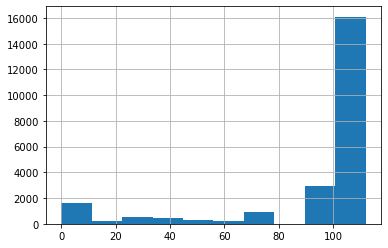

In [23]:
df['GD'].hist();

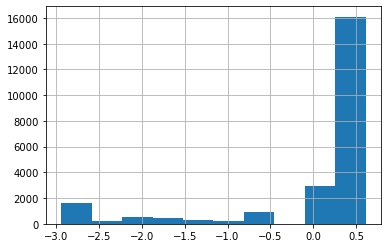

In [24]:
df['GD'] = standardize(df['GD'])
df['GD'] = df['GD'].astype(theano.config.floatX)
df['GD'].hist();

## Observed RI values from generative model (clade)

In [25]:
# True parameter values of generative linear function.  As much as possible, deriving these should follow the same
# pattern as the hyperpriors/priors of the Bayesian model.

# Everything uses the same a, so don't index.

# v0 and v1 derive from the same c, but each is linked to just one of a pair.  Each RI calc thus calls c twice.
# Split pairs to make species1 index and species2 index.  The key is having the node-species pair equal in both indices.
# Also make a clade1 and clade2 index.

# Each clade starts with a unique b, then pairs average them.  Therefore, b should be indexed by clade intersections and the
# biogeo index.  Separate test is species or pair index.

a = 0.01 # Intercept
b = 0.01 # Slope
c = 0.01 # Velocity
# c1 = 0.01
err = 0.0015

In [65]:
# Get crown nodes for eight clades.
crowns = [
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Quercus"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Virentes"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Ponticae"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Protobalanus"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Lobatae"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Cyclobalanopsis"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Ilex"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Cerris")
]
crowns

[393, 394, 405, 417, 425, 426, 422, 423]

In [66]:
import statistics
scalars = []
for num in crowns:
    gc = gtree.copy()
    node =  gc.get_feature_dict("idx")[num]
    subtree = toytree.tree(node)
    scalars.append(statistics.mean(subtree.get_edge_values("dist")))

scalars

[3.3735734843827196,
 1.7763568394002505e-15,
 0.0,
 2.7453808593750004,
 1.2631034580596057,
 8.594007971225867,
 2.3195943587238093,
 3.7582222247000017]

In [67]:
# Define base slope and velocity values at crowns.
slopes = {
    393: b * scalars[0], # Quercus
    394: b * scalars[1], # Virentes
    405: b, # Ponticae (don't scale)
    417: b * scalars[3], # Protobalanus
    425: b * scalars[4], # Lobatae
    426: b * scalars[5], # Cyclobalanopsis
    422: b * scalars[6], # Ilex
    423: b * scalars[7], # Cerris
}

velocities = {
    393: c, # Quercus
    394: c, # Virentes
    405: c, # Ponticae
    417: c, # Protobalanus
    425: c, # Lobatae
    426: c, # Cyclobalanopsis
    422: c, # Ilex
    423: c, # Cerris
}

# For clade model: scale b in some way by the average length of the child tips of these nodes.

# For species model: assign from a single distribution instead.

In [68]:
# For each crown node: get descendants, then generate slopes from a clade-specific normal distribution.
rng = np.random.default_rng()
allslope = {}
for node in slopes:
    idxs = gtree.get_node_descendant_idxs(node)
    for idx in idxs:
        allslope.update({idx: rng.normal(slopes[node], 0.001)})

In [70]:
# Generate velocities.
allvelo = {}
for node in velocities:
    idxs = gtree.get_node_descendant_idxs(node)
    for idx in idxs:
        allvelo.update({idx: rng.normal(velocities[node], 0.001)})

In [71]:
# Set slope and velocity values on tree.
gtree = gtree.set_node_values("slope", allslope)
gtree = gtree.set_node_values("velocity", allvelo)

# Assign clade colors to nodes (for tree visual).
for node, color in zip(velocities, toytree.colors[:8]):
    for idx in gtree.get_node_descendant_idxs(node):
        gtree.idx_dict[idx].color = color

In [72]:
# Iterate to fill RI values.
for idx in df.index:
    
    # Get node indices.
    idx0 = df.loc[idx, "Pairs"][0]
    idx1 = df.loc[idx, "Pairs"][1]
    
    # Get node velocities.
    v0 = gtree.idx_dict[idx0].velocity
    v1 = gtree.idx_dict[idx1].velocity
    
    # Get node slopes.
    b_avg = (gtree.idx_dict[idx0].slope + gtree.idx_dict[idx1].slope) / 2
    
    # Generate error.
    error = rng.normal(0, err)
    
    # Calculate RI.  b_avg/v0/v1 were already drawn from normal distributions, here draw for a as well.
    # Also, why do I divide GD by 2? Add to Bayesian model.
    ri = rng.normal(a, 0.001) + ((b_avg + v0 + v1) * (df.loc[idx, "GD"] / 2.0)) + error 
    
    # Normalize the RI value on a 0-1 scale.  (Wrong spot! Left censoring too early.)
    # ri = max(0.0, min(1.0, ri))
    
    # Store RI value in dataframe.
    df.loc[idx, "Observed_RI"] = ri
    
df['Observed_RI'] = df['Observed_RI'].astype(theano.config.floatX)

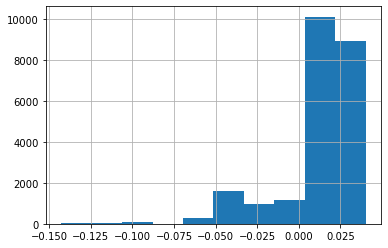

In [73]:
df['Observed_RI'].hist();

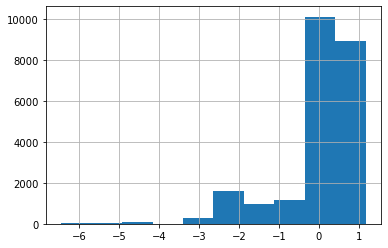

In [74]:
df['Observed_RI'] = standardize(df['Observed_RI']) 
df['Observed_RI'].hist();
# Censor after here instead? May address treedepth problem.  Would censoring the generative data be biased?

In [31]:
# INCORRECT CENSORING!! Trying solution from pymc3 discourse.

#for idx in df.index:
    #df.loc[idx, 'Observed_RI'] = max(0.0, min(1.0, df['Observed_RI'][idx]))

In [75]:
df

Pairs    Range_pairs       Species1  Species1_index  Clade1_index  \
0      (215, 214)  ((POLYGON ...  Quercus aj...            215              0   
1      (215, 213)  ((POLYGON ...  Quercus aj...            215              0   
2      (215, 212)  ((POLYGON ...  Quercus aj...            215              0   
3      (215, 211)  ((POLYGON ...  Quercus aj...            215              0   
4      (215, 210)  ((POLYGON ...  Quercus aj...            215              0   
...           ...            ...            ...            ...            ...   
23215      (3, 1)  (POLYGON (...  Quercus br...              3              7   
23216      (3, 0)  (POLYGON (...  Quercus br...              3              7   
23217      (2, 1)  ((POLYGON ...  Quercus it...              2              7   
23218      (2, 0)  ((POLYGON ...  Quercus it...              2              7   
23219      (1, 0)  ((POLYGON ...  Quercus ac...              1              7   

            Species2  Species2_index  Clade2_index      Clade_duo  \
0      Quercus tu...            214              0  Quercus + ...   
1      Quercus to...            213              0  Quercus + ...   
2      Quercus ob...            212              0  Quercus + ...   
3      Quercus ch...            211              0  Quercus + ...   
4      Quercus gr...            210              0  Quercus + ...   
...              ...            ...            ...            ...   
23215  Quercus ac...              1              7  Cerris + C...   
23216  Quercus ch...              0              7  Cerris + C...   
23217  Quercus ac...              1              7  Cerris + C...   
23218  Quercus ch...              0              7  Cerris + C...   
23219  Quercus ch...              0              7  Cerris + C...   

       Clade_duo_index  Overlap  Lit        GD  Observed_RI  
0                  0          1  NaN -0.895564    -0.991458  
1                  0          1  NaN -0.489835    -0.600256  
2                  0          1  NaN -0.489835    -0.768852  
3                  0          1  NaN -0.489835    -0.576766  
4                  0          1  NaN -0.489835    -0.641481  
...              ...        ...  ...       ...          ...  
23215             35          0  NaN -2.837504    -3.137559  
23216             35          0  NaN -2.837504    -3.416575  
23217             35          0  NaN -2.887549    -3.172472  
23218             35          0  NaN -2.887549    -3.417121  
23219             35          1  NaN -2.912571    -3.386932  

[23220 rows x 14 columns]

In [76]:
dfs = df.sample(frac = 0.1)
dfs

Pairs    Range_pairs       Species1  Species1_index  Clade1_index  \
5196    (190, 68)  (POLYGON (...  Quercus co...            190              0   
5473   (188, 168)  (POLYGON (...  Quercus la...            188              0   
3191   (200, 128)  (POLYGON (...  Quercus po...            200              0   
9572   (165, 117)  (POLYGON (...  Quercus py...            165              0   
401     (214, 27)  (POLYGON (...  Quercus tu...            214              0   
...           ...            ...            ...            ...            ...   
21294    (62, 34)  ((POLYGON ...  Quercus pa...             62              4   
18457     (98, 9)  (POLYGON (...  Quercus ed...             98              4   
14951   (129, 12)  (POLYGON (...  Quercus ch...            129              3   
10115   (162, 63)  ((POLYGON ...  Quercus ha...            162              0   
23012    (20, 17)  ((POLYGON ...  Quercus au...             20              6   

            Species2  Species2_index  Clade2_index      Clade_duo  \
5196   Quercus sh...             68              4  Quercus + ...   
5473   Quercus pu...            168              0  Quercus + ...   
3191   Quercus to...            128              3  Quercus + ...   
9572   Quercus il...            117              4  Quercus + ...   
401    Quercus mo...             27              6  Quercus + ...   
...              ...            ...            ...            ...   
21294  Quercus au...             34              5  Lobatae + ...   
18457  Quercus af...              9              7  Lobatae + ...   
14951  Quercus li...             12              7  Protobalan...   
10115  Quercus il...             63              4  Quercus + ...   
23012  Quercus ro...             17              6    Ilex + Ilex   

       Clade_duo_index  Overlap  Lit        GD  Observed_RI  
5196               4          0  NaN  0.609354     0.679142  
5473               0          0  NaN  0.366135     0.649888  
3191               3          0  NaN  0.609354     0.358664  
9572               4          0  NaN  0.609354     0.792141  
401                6          0  NaN  0.609354     0.627473  
...              ...        ...  ...       ...          ...  
21294             27          0  NaN -0.087368    -0.220017  
18457             29          0  NaN  0.351884     0.295325  
14951             25          0  NaN  0.351884     0.212618  
10115              4          0  NaN  0.609354     0.762289  
23012             33          0  NaN -2.557564    -3.252309  

[2322 rows x 14 columns]

In [78]:
nsub_pairs = len(dfs.Pairs)
# nsub_clade_duo = len(dfs.Clade_duo.unique())

s1_idx = dfs.Species1_index.values
s2_idx = dfs.Species2_index.values
clade1_idx = dfs.Clade1_index.values
clade2_idx = dfs.Clade2_index.values
clade_duo_idx = dfs.Clade_duo_index.values

# litsub_idx = dfs.Lit.values
bgsub_idx = dfs.Overlap.values

## Hierarchical model with subsampling

In [55]:
# Build hierarchical model.
with pm.Model() as hierarchical_model_sub:
    
    # Hyperpriors for group nodes.
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0) # Slope hyperprior
    sigma_a = pm.HalfCauchy("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0) # Intercept hyperprior
    sigma_b = pm.HalfCauchy("sigma_b", 1.0)
    mu_c0 = pm.Normal("mu_c0", mu=0.0, sigma=10.0) # C0 hyperprior
    sigma_c0 = pm.HalfCauchy("sigma_c0", 1.0)
    mu_c1 = pm.Normal("mu_c1", mu=0.0, sigma=10.0) # C1 hyperprior
    sigma_c1 = pm.HalfCauchy("sigma_c1", 1.0)
    
    # Regular priors.
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=nsub_pairs) 
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=nsub_pairs)
    c0 = pm.Normal("c0", mu=mu_c0, sigma=sigma_c0, shape=nsub_pairs)
    c1 = pm.Normal("c1", mu=mu_c1, sigma=sigma_c1, shape=nsub_pairs)
    
    # Error term.
    eps = pm.Lognormal("eps", mu=-1.0, sigma=1.0)
    
    # Build linear equation.
    RI_est = a[bgsub_idx][cladesub_idx] + (
        b[bgsub_idx][cladesub_idx] + c0[bgsub_idx][cladesub_idx] + c1[bgsub_idx][cladesub_idx]) * dfs.GD.values
    
    # Data likelihood.
    Y = pm.Normal("Y", RI_est, sigma=eps, observed=dfs.Observed_RI)

In [ ]:
# Inference button (TM)!
with hierarchical_model_sub:
    hierarchical_trace_sub = pm.sample(1000, tune = 500, target_accept = 0.9, max_treedepth = 15, chains = 2, cores = 8)

In [39]:
pm.summary(hierarchical_trace_sub, var_names = ['mu_a', 'mu_b', 'mu_c0', 'mu_c1', 
                                                'sigma_a', 'sigma_b', 'sigma_c0', 'sigma_c1', 'eps'])

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_a      -1.666   5.436   -9.168   10.126      2.869    2.221       4.0   
mu_b      15.072  34.496   -5.398   88.685     21.433   17.660       3.0   
mu_c0    -24.293  38.556 -107.623    3.764     19.683   15.443       4.0   
mu_c1      8.278  45.010  -47.520  107.303     25.629   20.181       3.0   
sigma_a    6.806   2.800    2.981   12.765      1.718    1.380       3.0   
sigma_b    1.358   0.387    0.695    1.979      0.193    0.148       4.0   
sigma_c0   1.795   0.549    0.896    2.690      0.249    0.188       5.0   
sigma_c1   1.274   0.690    0.525    2.533      0.413    0.330       3.0   
eps        0.296   0.004    0.287    0.304      0.000    0.000    1498.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
mu_a         4.0       4.0      30.0   1.55  
mu_b         3.0       4.0      12.0   1.53  
mu_c0        4.0       4.0      20.0   1.56  
mu_c1        3.0       3.0      13.0   2.02  
sigma_a      3.0       3.0      15.0   1.93  
sigma_b      4.0       3.0      14.0   1.58  
sigma_c0     5.0       5.0      15.0   1.34  
sigma_c1     3.0       3.0      11.0   1.75  
eps       1497.0    1490.0    1614.0   1.00

In [37]:
# Final Y values: take means of four variables and GD for all pairs, calculate Y, add that to heatmap.

## Non-centered hierarchical model with subsampling

In [37]:
# Build hierarchical model.
with pm.Model() as hierarchical_nc:
    
    # Hyperpriors for group nodes.
    mu_a = pm.Normal("mu_a", mu=0.0, sd=1.0) # Slope hyperprior
    sigma_a = pm.HalfCauchy("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sd=1.0) # Intercept hyperprior
    sigma_b = pm.HalfCauchy("sigma_b", 1.0)
    mu_c0 = pm.Normal("mu_c0", mu=0.0, sd=1.0) # C0 hyperprior
    sigma_c0 = pm.HalfCauchy("sigma_c0", 1.0)
    mu_c1 = pm.Normal("mu_c1", mu=0.0, sd=1.0) # C1 hyperprior
    sigma_c1 = pm.HalfCauchy("sigma_c1", 1.0)
    
    # Regular priors with offsets.
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=nsub_pairs)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=nsub_pairs)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
    c0_offset = pm.Normal('c0_offset', mu=0, sd=1, shape=nsub_pairs)
    c0 = pm.Deterministic("c0", mu_c0 + c0_offset * sigma_c0)
    c1_offset = pm.Normal('c1_offset', mu=0, sd=1, shape=nsub_pairs)
    c1 = pm.Deterministic("c1", mu_c1 + c1_offset * sigma_c1)
    
    # Error term.
    eps = pm.Lognormal("eps", mu=-1.0, sigma=1.0)
    
    # Build linear equation.
    RI_est = a[bgsub_idx][cladesub_idx] + (
        b[bgsub_idx][cladesub_idx] + c0[bgsub_idx][cladesub_idx] + c1[bgsub_idx][cladesub_idx]) * dfs.GD.values
    
    # Data likelihood.
    Y = pm.Normal("Y", RI_est, sigma=eps, observed=dfs.Observed_RI)

In [38]:
with hierarchical_nc:
    htrace_nc = pm.sample(1000, tune = 500, target_accept = 0.95, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1_offset, c0_offset, b_offset, a_offset, sigma_c1, mu_c1, sigma_c0, mu_c0, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1341 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [39]:
with hierarchical_nc:
    htrace_nc = pm.sample(1000, tune = 1000, target_accept = 0.98, max_treedepth = 15, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1_offset, c0_offset, b_offset, a_offset, sigma_c1, mu_c1, sigma_c0, mu_c0, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9230 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [42]:
pm.summary(htrace_nc, var_names = ['a_offset'])

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a_offset[0]     0.362  0.629  -0.743    1.528      0.021    0.015     903.0   
a_offset[1]    -0.609  0.626  -1.818    0.467      0.021    0.015     888.0   
a_offset[2]     0.005  1.012  -2.011    1.769      0.019    0.025    2743.0   
a_offset[3]    -0.007  1.008  -1.879    2.020      0.021    0.024    2347.0   
a_offset[4]     0.000  1.026  -1.839    1.949      0.021    0.026    2477.0   
...               ...    ...     ...      ...        ...      ...       ...   
a_offset[2317]  0.009  0.973  -1.767    1.793      0.018    0.023    3001.0   
a_offset[2318] -0.015  0.981  -1.885    1.798      0.018    0.022    2861.0   
a_offset[2319]  0.002  0.975  -1.676    1.854      0.021    0.021    2219.0   
a_offset[2320]  0.012  1.046  -2.034    1.860      0.020    0.028    2640.0   
a_offset[2321] -0.001  1.006  -2.036    1.719      0.021    0.024    2279.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
a_offset[0]      890.0     942.0    1043.0   1.00  
a_offset[1]      888.0     903.0    1111.0   1.00  
a_offset[2]      803.0    2748.0    1516.0   1.00  
a_offset[3]      849.0    2311.0    1480.0   1.00  
a_offset[4]      801.0    2481.0    1369.0   1.00  
...                ...       ...       ...    ...  
a_offset[2317]   905.0    3037.0    1504.0   1.00  
a_offset[2318]   997.0    2844.0    1526.0   1.00  
a_offset[2319]  1073.0    2216.0    1597.0   1.01  
a_offset[2320]   720.0    2646.0    1047.0   1.00  
a_offset[2321]   847.0    2291.0    1358.0   1.00  

[2322 rows x 11 columns]

In [75]:
with hierarchical_nc:
    htrace_nc = pm.sample(2000, tune = 2000, target_accept = 0.99, max_treedepth = 15, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1_offset, c0_offset, b_offset, a_offset, sigma_c1, mu_c1, sigma_c0, mu_c0, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 30660 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


## Censored regression example

In [68]:
m, c, σ, N = 1, 0, 2, 200
x = np.random.uniform(-10, 10, N)
y = np.random.normal(m * x + c, σ)
bounds = [-5, 5]

def censored_regression(x, y, bounds):
    
    # data pre-processing
    left_censored = (y <= bounds[0])
    x_lc = x[left_censored]
    y_lc = y[left_censored]
    
    right_censored = (y >= bounds[1])
    x_rc = x[right_censored]
    y_rc = y[right_censored]
    
    uncensored = (y>bounds[0]) & (y<bounds[1])
    x = x[uncensored]
    y = y[uncensored]

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        k = pm.Normal("k", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=(m + k) * x + c, sd=σ, observed=y)
        left_censored = pm.Potential("left_censored", normal_lcdf((m + k) * x_lc + c, σ, y_lc))
        right_censored = pm.Potential("right_censored", normal_lccdf((m + k) * x_rc + c, σ, y_rc))

    with model:
        trace = pm.sample()

    return model, trace

In [69]:
censored_regression(x, y, bounds)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, c, k, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8803248089320832, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6863332790090424, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


(<pymc3.model.Model at 0x7f914a9c2710>,
 <MultiTrace: 4 chains, 1000 iterations, 5 variables>)

## Subsampled non-centered hierarchical model with censoring

In [ ]:
nsub_pairs = len(dfs.Pairs)
# nsub_clade_duo = len(dfs.Clade_duo.unique())

s1_idx = dfs.Species1_index.values
s2_idx = dfs.Species2_index.values
clade1_idx = dfs.Clade1_index.values
clade2_idx = dfs.Clade2_index.values
clade_duo_idx = dfs.Clade_duo_index.values

# litsub_idx = dfs.Lit.values
bg_idx = dfs.Overlap.values

In [239]:
def hierarchical_censored_regression(x, y, bounds):
    
    # Data pre-processing.
    left_censored = (y <= bounds[0])
    x_lc = x[left_censored]
    y_lc = y[left_censored]
    nsub_pairs_lc = len(dfs.Pairs[left_censored])
    bg_idx_lc = dfs.Overlap.values[left_censored]
    s1_idx_lc = dfs.Species1_index.values[left_censored]
    s2_idx_lc = dfs.Species2_index.values[left_censored]
    clade1_idx_lc = dfs.Clade1_index.values[left_censored]
    clade2_idx_lc = dfs.Clade2_index.values[left_censored]
    clade_duo_idx_lc = dfs.Clade_duo_index.values[left_censored]
    print(len(x_lc), len(y_lc), nsub_pairs_lc, len(bg_idx_lc), len(s1_idx_lc), len(s2_idx_lc),
          len(clade1_idx_lc), len(clade2_idx_lc), len(clade_duo_idx_lc))
    
    right_censored = (y >= bounds[1])
    x_rc = x[right_censored]
    y_rc = y[right_censored]
    nsub_pairs_rc = len(dfs.Pairs[right_censored])
    bg_idx_rc = dfs.Overlap.values[right_censored]
    s1_idx_rc = dfs.Species1_index.values[right_censored]
    s2_idx_rc = dfs.Species2_index.values[right_censored]
    clade1_idx_rc = dfs.Clade1_index.values[right_censored]
    clade2_idx_rc = dfs.Clade2_index.values[right_censored]
    clade_duo_idx_rc = dfs.Clade_duo_index.values[right_censored]
    print(len(x_rc), len(y_rc), nsub_pairs_rc, len(bg_idx_rc), len(s1_idx_rc), len(s2_idx_rc),
          len(clade1_idx_rc), len(clade2_idx_rc), len(clade_duo_idx_rc))
    
    uncensored = (y>bounds[0]) & (y<bounds[1])
    x = x[uncensored]
    y = y[uncensored]
    nsub_pairs_u = len(dfs.Pairs[uncensored])
    bg_idx_u = dfs.Overlap.values[uncensored]
    s1_idx_u = dfs.Species1_index.values[uncensored]
    s2_idx_u = dfs.Species2_index.values[uncensored]
    clade1_idx_u = dfs.Clade1_index.values[uncensored]
    clade2_idx_u = dfs.Clade2_index.values[uncensored]
    clade_duo_idx_u = dfs.Clade_duo_index.values[uncensored]
    print(len(x), len(y), nsub_pairs_u, len(bg_idx_u), len(s1_idx_u), len(s2_idx_u),
          len(clade1_idx_u), len(clade2_idx_u), len(clade_duo_idx_u))
    
    with pm.Model() as model:
    
        # Hyperpriors.
        mu_a = pm.Normal("mu_a", mu=0.0, sd=10.0) # Intercept hyperprior
        sigma_a = pm.HalfCauchy("sigma_a", 5.0)
        mu_b = pm.Normal("mu_b", mu=0.0, sd=1.0) # Slope hyperprior
        sigma_b = pm.HalfCauchy("sigma_b", 1.0)
        mu_c = pm.Normal("mu_c", mu=0.0, sd=1.0) # Velocity hyperprior
        sigma_c = pm.HalfCauchy("sigma_c", 1.0)
        
        # Priors for uncensored data. 
        a = pm.Normal("a", mu=0, sd=1, shape=nsub_pairs_u)
        b = pm.Normal("b", mu=0, sd=1, shape=nsub_pairs_u)
        c = pm.Normal("c", mu=0, sd=1, shape=nsub_pairs_u)
        
        # Priors for left censored data. 
        a_lc = pm.Normal("a_lc", mu=0, sd=1, shape=nsub_pairs_lc)
        b_lc = pm.Normal("b_lc", mu=0, sd=1, shape=nsub_pairs_lc)
        c_lc = pm.Normal("c_lc", mu=0, sd=1, shape=nsub_pairs_lc)
        
        # Priors for right censored data. 
        a_rc = pm.Normal("a_rc", mu=0, sd=1, shape=nsub_pairs_rc)
        b_rc = pm.Normal("b_rc", mu=0, sd=1, shape=nsub_pairs_rc)
        c_rc = pm.Normal("c_rc", mu=0, sd=1, shape=nsub_pairs_rc)
        
        # Linear equation.
        RI_est = (mu_a + a[bg_idx_u][clade_duo_idx_u] * sigma_a) + (((mu_b + b[bg_idx_u][clade_duo_idx_u] * sigma_b) + 
                                        (mu_c + c[clade1_idx_u] * sigma_c) + 
                                        (mu_c + c[clade2_idx_u] * sigma_c)) * (x / 2))
        
        # Error term.
        eps = pm.Lognormal("eps", mu=-1.0, sigma=1.0)
        
        # Data likelihood.
        Y = pm.Normal("Y", RI_est, sigma=eps, observed=y)
        
        # Left censoring.
        left_censored = pm.Potential("left_censored", normal_lcdf((mu_a + a_lc[bg_idx_lc][clade_duo_idx_lc] * sigma_a) + 
                                                                  (((mu_b + b_lc[bg_idx_lc][clade_duo_idx_lc] * sigma_b) + 
                                                                    (mu_c + c_lc[clade1_idx_lc] * sigma_c) + 
                                                                    (mu_c + c_lc[clade2_idx_lc] * sigma_c)) * (x_lc / 2)),
                                                                 eps, y_lc))
        
        # Right censoring.
        right_censored = pm.Potential("right_censored", normal_lccdf((mu_a + a_rc[bg_idx_rc][clade_duo_idx_rc] * sigma_a) + 
                                                                  (((mu_b + b_rc[bg_idx_rc][clade_duo_idx_rc] * sigma_b) + 
                                                                    (mu_c + c_rc[clade1_idx_rc] * sigma_c) + 
                                                                    (mu_c + c_rc[clade2_idx_rc] * sigma_c)) * (x_rc / 2)),
                                                                    eps, y_rc))
        
    graph = pm.model_to_graphviz(model)
                                     
    with model:
        trace = pm.sample(1000, tune = 2000, target_accept = 0.99, max_treedepth = 12, chains = 2, cores = 8)

    return model, graph, trace

In [187]:
# trace = pm.sample(1000, tune = 1000, target_accept = 0.99, chains = 2, cores = 8)
# a/b indexed, new non-centering
hcmodel, hgraph, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c_rc, b_rc, a_rc, c_lc, b_lc, a_lc, c, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3662 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [191]:
# trace = pm.sample(1000, tune = 2000, target_accept = 0.99, chains = 2, cores = 8)
# a/b indexed, new non-centering
# similar results (4-6 div) with wider a hyper, may just be noise
# treedepth = 12 is min
hcmodel, hgraph, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c_rc, b_rc, a_rc, c_lc, b_lc, a_lc, c, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 5307 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [235]:
# trace = pm.sample(1000, tune = 1500, target_accept = 0.99, max_treedepth = 11, chains = 2, cores = 8)
hcmodel, hgraph, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653 653 653
29 29 29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c_rc, b_rc, a_rc, c_lc, b_lc, a_lc, c, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 6920 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9640769369504572, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9580242815143802, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [236]:
pm.summary(hctrace, var_names = ['sigma_c', 'mu_c', 'sigma_b', 'mu_b', 'sigma_a', 'mu_a'])
# pm.summary(hctrace, var_names = ['c'])['r_hat'].hist();

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
sigma_c  0.130  0.060   0.040    0.234      0.004    0.003     196.0   196.0   
mu_c     0.981  0.572  -0.214    2.093      0.053    0.038     115.0   115.0   
sigma_b  1.033  1.467   0.000    3.109      0.109    0.077     183.0   183.0   
mu_b     0.611  0.901  -0.998    2.319      0.062    0.044     212.0   212.0   
sigma_a  5.990  4.598   0.760   15.294      0.526    0.373      77.0    77.0   
mu_a    -2.466  3.696  -9.366    4.248      0.586    0.446      40.0    35.0   

         ess_bulk  ess_tail  r_hat  
sigma_c     178.0     251.0   1.01  
mu_c        129.0     112.0   1.01  
sigma_b      91.0     163.0   1.00  
mu_b        212.0     401.0   1.01  
sigma_a      93.0     156.0   1.04  
mu_a         47.0      44.0   1.07

In [240]:
# trace = pm.sample(1000, tune = 2000, target_accept = 0.99, max_treedepth = 12, chains = 2, cores = 8)
hcmodel, hgraph, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653 653 653
29 29 29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c_rc, b_rc, a_rc, c_lc, b_lc, a_lc, c, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 11945 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9706254288533336, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Runs from older setup below.

In [82]:
# trace = pm.sample(1000, tune = 500, target_accept = 0.95, chains = 2, cores = 8) - new gen math and related changes
# pm.summary(hctrace, var_names = ['sigma_c', 'mu_c', 'sigma_b', 'mu_b', 'sigma_a', 'mu_a'])
# sigma_a: ~1.3 rhat at 5, 1.61 at 1, 1.09 at 50, 1.23 at 100 (there for now)
hcmodel, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1r_offset, c0r_offset, br_offset, ar_offset, c1l_offset, c0l_offset, bl_offset, al_offset, c1_offset, c0_offset, b_offset, a_offset, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1764 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [104]:
# trace = pm.sample(1000, tune = 500, target_accept = 0.98, chains = 2, cores = 8) - new gen math and related changes, SA100
hcmodel, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1r_offset, c0r_offset, br_offset, ar_offset, c1l_offset, c0l_offset, bl_offset, al_offset, c1_offset, c0_offset, b_offset, a_offset, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1758 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [139]:
# trace = pm.sample(1000, tune = 500, target_accept = 0.98, chains = 2, cores = 8)
# after noticing that intercept/slope were mixed up, SA50 SB10
hcmodel, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1r_offset, c0r_offset, br_offset, ar_offset, c1l_offset, c0l_offset, bl_offset, al_offset, c1_offset, c0_offset, b_offset, a_offset, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3575 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [152]:
# trace = pm.sample(1000, tune = 500, target_accept = 0.98, chains = 2, cores = 8)
# SA50 SB10 fixed error in censored equations
hcmodel, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1r_offset, c0r_offset, br_offset, ar_offset, c1l_offset, c0l_offset, bl_offset, al_offset, c1_offset, c0_offset, b_offset, a_offset, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2971 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


## Run non-centered hierarchical model with full dataset and censoring

In [ ]:
npairs = len(pairs)
nclades = len(df.Clades.unique())
lit_idx = df.Lit.values
bg_idx = df.Overlap.values
clade_idx = df.Clade_index.values

In [35]:
# Build hierarchical model.
with pm.Model() as hierarchical_model:
    
    # Hyperpriors for group nodes.
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=1.0) # Slope hyperprior
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=1.0) # Intercept hyperprior
    sigma_b = pm.HalfNormal("sigma_b", 1.0)
    mu_c0 = pm.Normal("mu_c0", mu=0.0, sigma=1.0) # C0 hyperprior
    sigma_c0 = pm.HalfNormal("sigma_c0", 1.0)
    mu_c1 = pm.Normal("mu_c1", mu=0.0, sigma=1.0) # C1 hyperprior
    sigma_c1 = pm.HalfNormal("sigma_c1", 1.0)
    
    # Regular priors.
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=npairs) # Clades for clade model, pairs for species model
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=npairs)
    c0 = pm.Normal("c0", mu=mu_c0, sigma=sigma_c0, shape=npairs)
    c1 = pm.Normal("c1", mu=mu_c1, sigma=sigma_c1, shape=npairs)
    
    # Error term.
    eps = pm.Lognormal("eps", mu=-1.0, sigma=1.0)
    
    # Build linear equation.
    RI_est = a[bg_idx][clade_idx] + (b + c0 + c1)[bg_idx][clade_idx] * df.GD.values
    
    # Data likelihood.
    Y = pm.Normal("Y", RI_est, sigma=eps, observed=df.Observed_RI.values)

In [36]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, target_accept = 0.9, chains = 2, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c1, mu_c1, sigma_c0, mu_c0, sigma_b, mu_b, sigma_a, mu_a]


ValueError: Not enough samples to build a trace.

In [33]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, chains = 2, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c1, mu_c1, sigma_c0, mu_c0, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8762 seconds.
The acceptance probability does not match the target. It is 0.9225032298294525, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
pm.summary(hierarchical_trace, var_names = ['a', 'b', 'c0', 'c1'])

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0]    0.013  0.000   0.013    0.013      0.000    0.000      20.0    20.0   
a[1]    0.014  0.000   0.014    0.014      0.000    0.000      68.0    68.0   
a[2]    0.243  0.697  -0.569    0.940      0.491    0.416       2.0     2.0   
a[3]    0.446  0.537  -0.100    0.996      0.379    0.321       2.0     2.0   
a[4]   -0.163  0.751  -0.924    0.609      0.530    0.449       2.0     2.0   
...       ...    ...     ...      ...        ...      ...       ...     ...   
c1[31] -0.118  0.491  -0.634    0.375      0.346    0.293       2.0     2.0   
c1[32] -0.400  0.629  -0.987    0.578      0.410    0.349       2.0     2.0   
c1[33]  0.099  0.223  -0.131    0.333      0.158    0.133       2.0     2.0   
c1[34]  0.326  0.074   0.167    0.389      0.049    0.042       2.0     2.0   
c1[35] -0.533  0.248  -0.778   -0.184      0.173    0.147       2.0     2.0   

        ess_bulk  ess_tail  r_hat  
a[0]        22.0      42.0   1.10  
a[1]        64.0     172.0   1.22  
a[2]         2.0      19.0   2.99  
a[3]         3.0      12.0   2.24  
a[4]         3.0      12.0   2.27  
...          ...       ...    ...  
c1[31]       3.0      16.0   1.93  
c1[32]       3.0      21.0   1.91  
c1[33]       3.0      11.0   2.16  
c1[34]       2.0      13.0   2.65  
c1[35]       3.0      13.0   2.16  

[144 rows x 11 columns]

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


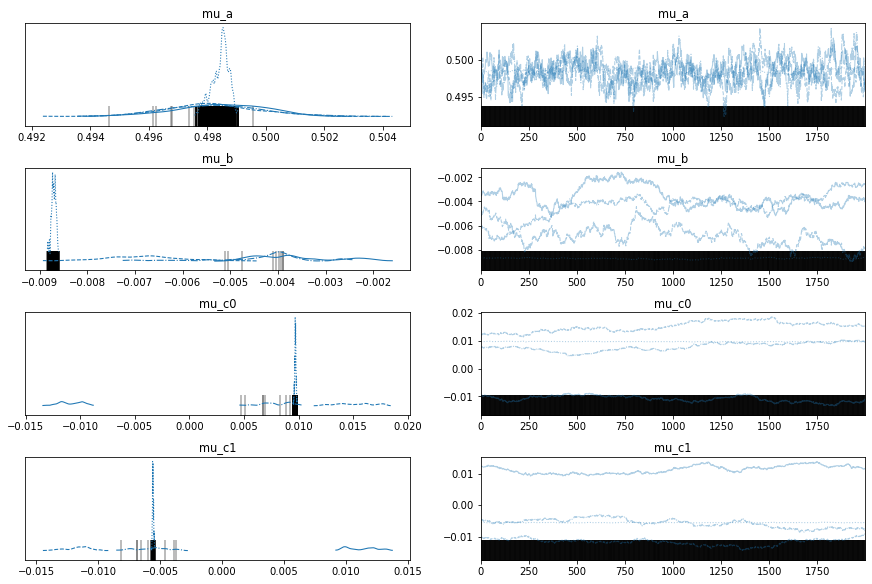

In [82]:
pm.traceplot(hierarchical_trace, var_names=["mu_a", "mu_b", "mu_c0", "mu_c1"]);